In [32]:
import string
import pandas as pd


import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from numpy.compat import unicode


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import svm
from sklearn.linear_model import SGDClassifier
import spacy
from sklearn.metrics import f1_score,precision_score,recall_score,hamming_loss,jaccard_score, accuracy_score


from tqdm import tqdm
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [33]:
df = pd.read_parquet('clean_v1.parquet')
df.reset_index(inplace=True, drop=True)

df.head()

Title  \
0                      find malloc double free error   
1                 mock asp.netmvc controller context   
2                                  list symbols file   
3  main performance differences varchar nvarchar ...   
4                            highpass lowpass filter   

                                                Body      Id  \
0  program application objectivec get error myapp...  971249   
1  controller context depend asp.net internals wa...   32640   
2  list symbols export file possible would also l...   34732   
3  work database small web app school use sql ser...   35366   
4  graphics audio edit process software often con...   35530   

                                   Tags  Score  ViewCount  AnswerCount  \
0  iphone objective-c memory-management     82      79057           13   
1      asp.net-mvc unit-testing mocking     70      48431            7   
2                             c++ c gcc    594     512500           11   
3            sql-server sql-server-2005    247     182380           14   
4                       algorithm audio     27      85513            6   

   FavoriteCount                                    Title_not_clean  \
0            0.0  how to find the cause of a malloc "double free...   
1            0.0             mocking asp.net-mvc controller context   
2            0.0            how do i list the symbols in a .so file   
3            0.0  what are the main performance differences betw...   
4            0.0           what are high-pass and low-pass filters?   

                                      Body_not_clean  
0  i'm programming an application in objective-c ...  
1  so the controller context depends on some asp....  
2  how do i list the symbols being exported from ...  
3  i'm working on a database for a small web app ...  
4  graphics and audio editing and processing soft...

In [34]:
def most_tags(dataframes, nbr_tags: int = 50):
    dataframe = dataframes.copy()
    vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: str(x).split(" "), token_pattern=None)
    tag_vect = vectorizer.fit_transform(dataframe["Tags"])
    tags = vectorizer.get_feature_names_out()
    freqs = tag_vect.sum(axis=0).A1
    result = list(zip(tags, freqs))
    tag_counts = pd.DataFrame(result, columns=['tag', 'tag_counts']).sort_values(['tag_counts'], ascending=False)

    tags_kept = list(tag_counts['tag'].head(nbr_tags))

    # print(f"Top ten tags  : {tags_kept[:10]}")
    print(f"Number of tags kept : {len(tags_kept)}")

    for le in tqdm(range(dataframe.shape[0])):
        a = []
        b = dataframe['Tags'][le].split(" ")

        for i in range(len(b)):
            for j in tags_kept:
                temp = b[i].strip()  #Stripping the white-spaces present(if any) around the tag
                if temp == j:
                    a.append(j)
        if a:
            dataframe.loc[le, 'Tags'] = " ".join(a)
        else:
            dataframe.loc[le, 'Tags'] = np.nan
    dataframe = dataframe.dropna()
    print(dataframe.shape)
    return dataframe

tabel = PrettyTable()

tabel.field_names=['Model', 'Precision', 'Recall', 'Jaccard_score', 'f1_score', "accuracy", 'Experiment title']

result = []

def scoring_metrics(model, exp_title, test_data, val, proba : bool, threshold : float = 0.40):
    if proba:
        exp_title = exp_title + f" seuil : {str(proba)} " + str(threshold)
        prediction = model.predict_proba(val)
        prediction = np.where(prediction > threshold, 1, 0)
    else:
        prediction = model.predict(val)
    precision = round(precision_score(test_data, prediction, average='weighted'), 2)
    recall = round(recall_score(test_data, prediction, average='weighted'), 2)
    jaccard = round(jaccard_score(test_data, prediction, average='weighted'), 2)
    accuracy = round(accuracy_score(test_data, prediction), 2)
    f1 = round(f1_score(test_data, prediction, average='weighted'), 2)
    tabel.add_row([model.estimator.__class__.__name__, precision, recall, jaccard, f1, accuracy, exp_title])
    print(f"model : {model.estimator.__class__.__name__}, precision: {precision}, recall: {recall}, jaccard_score : {jaccard}, F1-measure: {f1}, acc : {accuracy}")
    return model.estimator.__class__.__name__, precision, recall, jaccard, f1, accuracy, exp_title

In [35]:
# getting most relevant tags
data = most_tags(df, 10)

Number of tags kept : 10


100%|██████████| 62669/62669 [00:07<00:00, 8460.61it/s]

(39285, 10)


In [36]:
# making sure that each classes are represented at least two times
data.drop(
    data[data['Tags'].isin(data['Tags'].value_counts().loc[lambda x: x <= 10].reset_index()['index'].tolist())].index,
    inplace=True)
# sanity control that title and body doesn't have empty rows
data.drop(
    data[data["Title"] == ''].index,
    inplace=True)

data.drop(
    data[data["Body"] == ''].index,
    inplace=True)
data.reset_index(inplace=True, drop=True)

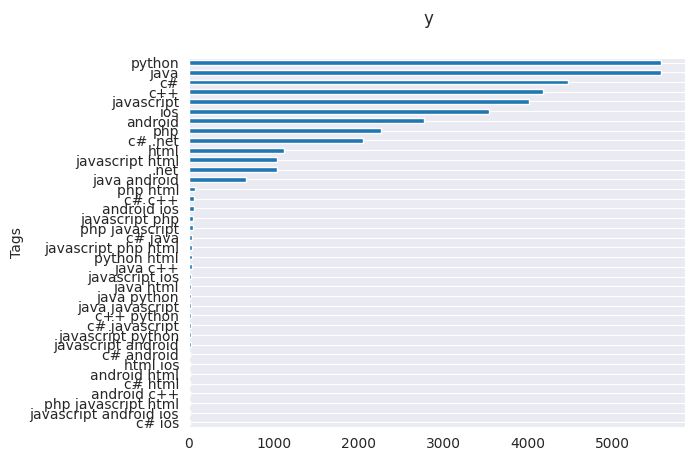

In [37]:

fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
data["Tags"].reset_index().groupby("Tags").count().sort_values(by=
                                                               "index").plot(kind="barh", legend=False,
                                                                             ax=ax).grid(axis='x')
plt.show()

In [38]:
mlb = MultiLabelBinarizer()
X = data["Title_not_clean"] + " . " + data["Body_not_clean"]
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=data['Tags'])

In [7]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [8]:
# from sentence_transformers import SentenceTransformer, InputExample, losses
# from torch.utils.data import DataLoader
#
# model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#                   InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]
# train_dataloader = DataLoader(X_train, batch_size=16) #shuffle=True
# train_loss = losses.CosineSimilarityLoss(model)
#
# #Tune the model
# model.fit(train_objectives=[(train_dataloader)], epochs=1, warmup_steps=100)

In [9]:
# sentence_embeddings = sbert_model.encode(X)

# print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
# print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

In [10]:
# from transformers import BertTokenizer
# token_lens = []
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# for txt in X_train:
#   tokens = tokenizer.encode(txt, max_length=512,truncation=True)
#   token_lens.append(len(tokens))

In [11]:
# import seaborn as sns
# sns.distplot(token_lens)
# # plt.xlim([0, 256]);
# # plt.xlabel('Token count')

In [12]:
# class GPReviewDataset(Dataset):

#   def __init__(self, reviews, targets, tokenizer, max_len):
#     self.reviews = reviews
#     self.targets = targets
#     self.tokenizer = tokenizer
#     self.max_len = max_len
  
#   def __len__(self):
#     return len(self.reviews)
  
#   def __getitem__(self, item):
#     review = str(self.reviews[item])
#     target = self.targets[item]

#     encoding = self.tokenizer.encode_plus(
#       review,
#       add_special_tokens=True,
#       max_length=self.max_len,
#       return_token_type_ids=False,
#       pad_to_max_length=True,
#       return_attention_mask=True,
#       return_tensors='pt',
#     )

#     return {
#       'review_text': review,
#       'input_ids': encoding['input_ids'].flatten(),
#       'attention_mask': encoding['attention_mask'].flatten(),
#       'targets': torch.tensor(target, dtype=torch.long)
#     }

In [13]:
# def create_data_loader(train, ytrain, tokenizer, max_len, batch_size):
#   ds = GPReviewDataset(
#     reviews=train,
#     targets=ytrain,
#     tokenizer=tokenizer,
#     max_len=max_len
#   )

#   return DataLoader(
#     ds,
#     batch_size=batch_size,
#     num_workers=4
#   )

In [14]:
# sentence_embeddings.shape

In [39]:
import torch
from transformers import AutoTokenizer, AutoModel

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained("all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
# model = AutoModel.from_pretrained("all-MiniLM-L6-v2").to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# device

In [40]:
tokenized_train = tokenizer(X_train.values.tolist(), padding = "max_length", truncation = True, return_tensors="pt",max_length=64, add_special_tokens=True)
tokenized_val = tokenizer(X_test.values.tolist() , padding = "max_length", truncation = True,  return_tensors="pt", max_length=64, add_special_tokens=True)

print(tokenized_train.keys())

#move on device (GPU)
# tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
# tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}



dict_keys(['input_ids', 'attention_mask'])


In [41]:
tokenized_train = {k: v.clone().detach().to(device) for k,v in tokenized_train.items()}
tokenized_val = {k: v.clone().detach().to(device) for k,v in tokenized_val.items()}

In [19]:
# !pip install sacremoses

In [42]:
len(tokenized_val['input_ids'])

9781

In [22]:
# model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased').to(device)

# with torch.no_grad():
#     encoded_layers, _ = model(**tokenized_train)

In [23]:
import gc

gc.collect()

0

In [43]:
torch.cuda.empty_cache()

In [44]:
gc.collect()

0

In [26]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [27]:
# tokenized_train

In [28]:
# batch_size = 10 
# for k, step in zip(tokenized_train['input_ids'], tokenized_train['attention_mask']):
#     # idx = step*batch_size
#     print(k, step)

In [29]:
# tokenized_train = tokenizer(X_train.values.tolist(), padding = "max_length", truncation = True, return_tensors="pt",max_length=64, add_special_tokens=True)
# tokenized_val = tokenizer(X_test.values.tolist() , padding = "max_length", truncation = True,  return_tensors="pt", max_length=64, add_special_tokens=True)

In [45]:
batch_size = 10

                                                                      

In [1]:
cls_train = []
with torch.no_grad():

    for step in range(len(X_train)//batch_size) :
        idx = step*batch_size
        inputs = {
        'input_ids': tokenized_train['input_ids'][idx:idx+batch_size],
        'attention_mask': tokenized_train['attention_mask'][idx:idx+batch_size],

        }
        hidden_val = model(**inputs)
        cls_train.append(hidden_val.last_hidden_state[:,0,:])

NameError: name 'torch' is not defined

In [ ]:
cls_val = []
with torch.no_grad():
    for step in range(len(X_test)//batch_size) :
        idx = step*batch_size

        inputs = {
        'input_ids': tokenized_val['input_ids'][idx:idx+batch_size],
        'attention_mask': tokenized_val['attention_mask'][idx:idx+batch_size],

        }
        hidden_val = model(**inputs)
        cls_val.append(hidden_val.last_hidden_state[:,0,:])

In [ ]:
# #get only the [CLS] hidden states
# cls_train = hidden_train.last_hidden_state[:,0,:]
# cls_val = hidden_val.last_hidden_state[:,0,:]

In [ ]:
t = []
for i, h in enumerate(cls_train):
    for j in h:
        
        t.append(j)


In [ ]:
len(t)

In [ ]:
k = []
for i, h in enumerate(cls_val):
    for j in h:
        
        k.append(j)

In [ ]:
len(k)

In [ ]:
x_train = [t.numpy() for t in t]
x_val = [t.numpy() for t in k]

In [ ]:
import os

import pandas as pd
import numpy as np

from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score

from xgboost import XGBClassifier
import spacy

import time
from tqdm import tqdm
from prettytable import PrettyTable

In [ ]:
def scoring_metrics(model, exp_title, test_data, val, proba : bool, threshold : float = 0.45):
    if proba:
        exp_title = exp_title + f" seuil : {str(proba)} " + str(threshold)
        prediction = model.predict_proba(val)
        prediction = np.where(prediction > threshold, 1, 0)
    else:
        prediction = model.predict(val)
    precision = round(precision_score(test_data, prediction, average='micro'), 3)
    recall = round(recall_score(test_data, prediction, average='micro'), 3)
    jaccard = round(jaccard_score(test_data, prediction, average='micro'), 3)

    f1 = round(f1_score(test_data, prediction, average='micro'), 3)
    # tabel.add_row([model.estimator.__class__.__name__, precision, recall, jaccard, f1, exp_title])
    print(f"model : {model.estimator.__class__.__name__}, precision: {precision}, recall: {recall}, jaccard_score : {jaccard}, F1-measure: {f1}")
    return model.estimator.__class__.__name__, precision, recall, jaccard, f1, exp_title

In [ ]:


clf = OneVsRestClassifier(LogisticRegression(n_jobs=-1))
clf.fit(x_train,y_train[:len(t)])
# clf.score(x_val,y_test[:6020])
score = scoring_metrics(clf, "t", y_test[:len(k)], x_val, False)

In [ ]:
score